# Import, Preprocessing Awal

## Impor Library yang Dibutuhkan

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings

warnings.filterwarnings('ignore')



## Load Dataset

In [ ]:
df = pd.read_csv('household_power_consumption.csv',
                  parse_dates={'datetime': ['Date', 'Time']},
                  infer_datetime_format=True,
                  na_values=['?'],
                  low_memory=False)

df.set_index('datetime', inplace=True)

print("Info Data Awal:")
df.info()
print("\nPreview Data:")
df.head()

Info Data Awal:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1048575 entries, 2006-12-16 17:24:00 to 2008-12-13 21:38:00
Data columns (total 7 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Global_active_power    1044506 non-null  float64
 1   Global_reactive_power  1044506 non-null  float64
 2   Voltage                1044506 non-null  float64
 3   Global_intensity       1044506 non-null  float64
 4   Sub_metering_1         1044506 non-null  float64
 5   Sub_metering_2         1044506 non-null  float64
 6   Sub_metering_3         1044506 non-null  float64
dtypes: float64(7)
memory usage: 64.0 MB

Preview Data:


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


## Data Cleaning Awal

In [ ]:
#  Handling Missing Values
print("Jumlah NaN per kolom sebelum cleaning:")
print(df.isnull().sum())

# Isi missing values dengan Forward Fill (FFill)
df.fillna(method='ffill', inplace=True)
# Isi NaN yang mungkin tersisa di awal deret dengan Backward Fill (BFill)
df.fillna(method='bfill', inplace=True)

print("\nJumlah NaN per kolom setelah cleaning (ffill & bfill):")
print(df.isnull().sum())
print("Missing values telah diisi menggunakan forward fill dan backward fill.")



Jumlah NaN per kolom sebelum cleaning:
Global_active_power      4069
Global_reactive_power    4069
Voltage                  4069
Global_intensity         4069
Sub_metering_1           4069
Sub_metering_2           4069
Sub_metering_3           4069
dtype: int64

Jumlah NaN per kolom setelah cleaning (ffill & bfill):
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64
Missing values telah diisi menggunakan forward fill dan backward fill.


`ffill` (forward fill), `bfill` (backward fill), dan `interpolate` adalah metode yang digunakan dalam pandas untuk mengisi nilai-nilai yang hilang (NaN). Pemilihan metode yang tepat tergantung pada karakteristik data dan asumsi yang ingin dibuat mengenai nilai yang hilang tersebut.

In [ ]:
#  Konversi Tipe Data ke Numerik
# Setelah cleaning NaN, pastikan semua kolom numerik benar tipenya
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')



In [ ]:
# Tambahkan Kolom 'other_consumption'
# Rumus: (global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3)
df['other_consumption'] = (df['Global_active_power'] * 1000 / 60) - df['Sub_metering_1'] - df['Sub_metering_2'] - df['Sub_metering_3']

# Pastikan other_consumption tidak negatif (konsumsi tidak bisa negatif)
df['other_consumption'] = np.maximum(0, df['other_consumption'])

## Agregasi ke Daily Data

In [ ]:
#  Agregasi Data ke Harian
df_daily = df.resample('D').agg({
    'Global_active_power': 'sum',
    'Global_reactive_power': 'mean',
    'Voltage': 'mean',
    'Global_intensity': 'mean',
    'Sub_metering_1': 'sum',
    'Sub_metering_2': 'sum',
    'Sub_metering_3': 'sum',
    'other_consumption': 'sum'
})

# Menambahkan konstanta kecil untuk model multiplicative. Kalau pakai additive tidak perlu

df_daily['Global_active_power_adjusted'] = df_daily['Global_active_power'] + 0.001
# Kemudian nantinya gunakan 'Global_active_power_adjusted' untuk dekomposisi dan model multiplikatif

In [ ]:
df_daily.isnull().sum()

,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0
other_consumption,0
Global_active_power_adjusted,0


## Data Cleaning Setelah Resample/Transformasi

In [ ]:
# Kembali isi NaN yang mungkin muncul setelah resample (jarang, tapi jaga-jaga)
df_daily.fillna(method='ffill', inplace=True)
df_daily.fillna(method='bfill', inplace=True)

# Pastikan tidak ada nilai negatif
for col in df_daily.columns:
    df_daily[col] = np.maximum(0, df_daily[col])

print("Info Data Harian Setelah Agregasi:")
df_daily.info()
print(f"\nUkuran Data Harian: {df_daily.shape[0]} hari")
print("\nPreview Data Harian:")
df_daily.head()



Info Data Harian Setelah Agregasi:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 729 entries, 2006-12-16 to 2008-12-13
Freq: D
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Global_active_power           729 non-null    float64
 1   Global_reactive_power         729 non-null    float64
 2   Voltage                       729 non-null    float64
 3   Global_intensity              729 non-null    float64
 4   Sub_metering_1                729 non-null    float64
 5   Sub_metering_2                729 non-null    float64
 6   Sub_metering_3                729 non-null    float64
 7   other_consumption             729 non-null    float64
 8   Global_active_power_adjusted  729 non-null    float64
dtypes: float64(9)
memory usage: 57.0 KB

Ukuran Data Harian: 729 hari

Preview Data Harian:


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,other_consumption,Global_active_power_adjusted
datetime,,,,,,,,,
2006-12-16,1209.176,0.088187,236.243763,13.082828,0.0,546.0,4926.0,14680.933333,1209.177
2006-12-17,3390.460,0.156949,240.087028,9.999028,2033.0,4187.0,13341.0,36946.666667,3390.461
2006-12-18,2203.826,0.112356,241.231694,6.421667,1063.0,2621.0,14018.0,19028.433333,2203.827
2006-12-19,1666.194,0.104821,241.999313,4.926389,839.0,7602.0,6197.0,13131.900000,1666.195
2006-12-20,2225.748,0.111804,242.308062,6.467361,0.0,2648.0,14063.0,20384.800000,2225.749


# Exploratory Data Analysis (EDA) pada Daily Data

## Visualisasi Time Series
(Target Global_active_power)

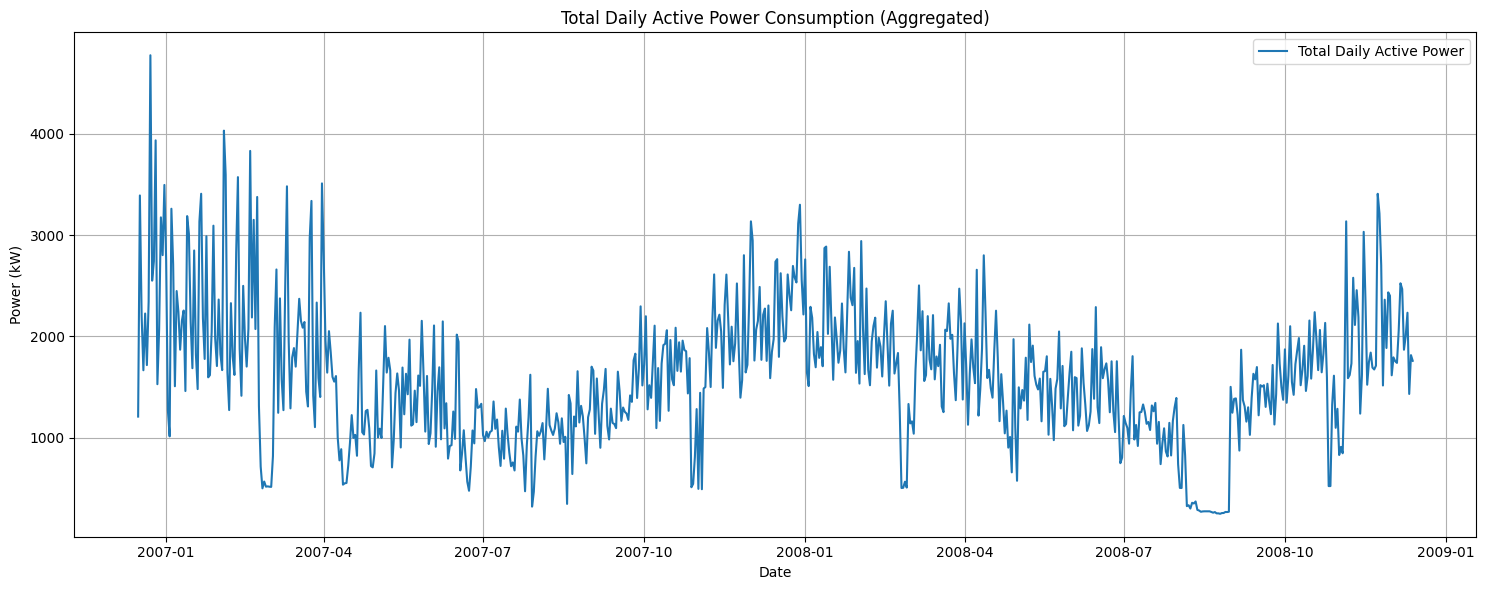

In [ ]:
# Visualisasi
plt.figure(figsize=(15, 6))
plt.plot(df_daily.index, df_daily['Global_active_power'], label='Total Daily Active Power')
plt.title('Total Daily Active Power Consumption (Aggregated)')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Dari plot, kita bisa melihat pola trend. Terlihat ada penurunan konsumsi dari awal 2007 hingga pertengahan 2007, lalu secara umum mengalami kenaikan hingga akhir 2008.

Trend-nya fluktuatif. Variabilitas harian sangat tinggi, ada beberapa penurunan tajam mendadak (kemungkinan anomali atau data hilang).

Seasonal atau siklus: Tidak terlalu tampak jelas secara visual (karena noise tinggi), tapi fluktuasi harian terlihat konsisten.

## Decomposition

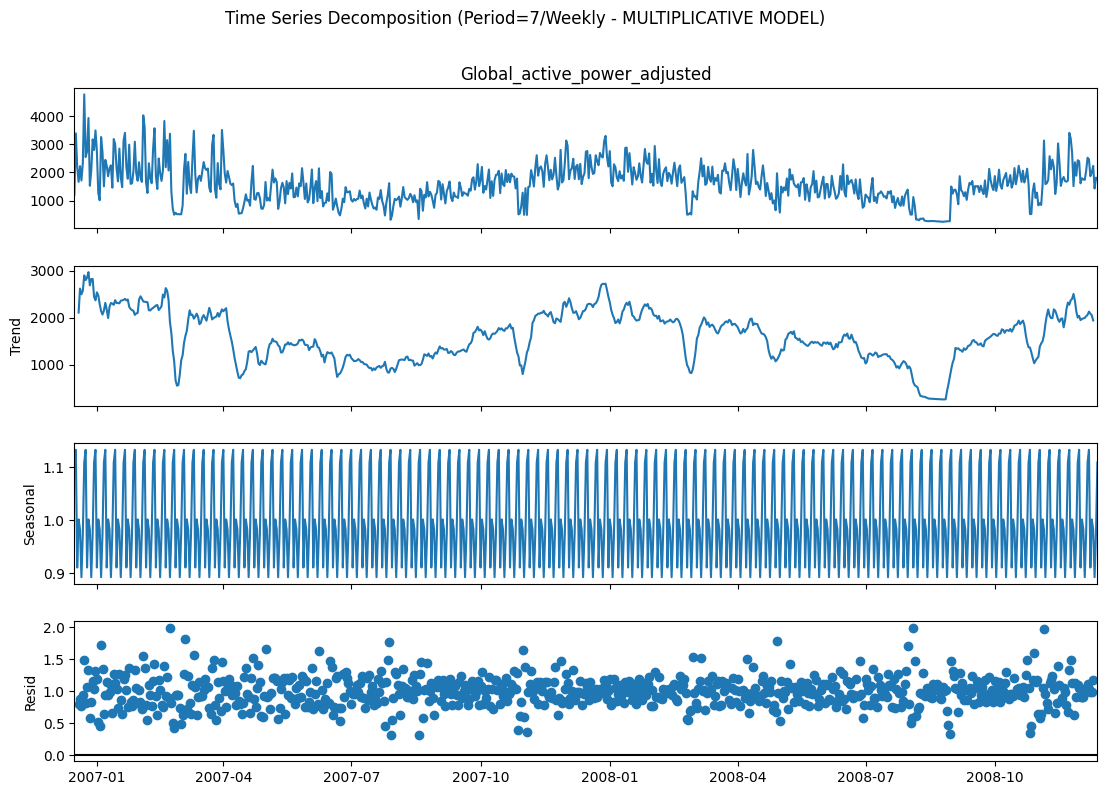

In [ ]:
# membuat decomposition plot dengan period=7.
# menggunakan fitur yang sudah di-adjust karena menggunakan model multiplicative. Kalau pakai yang additive tidak perlu pakau yang adjusted.
decomposition_weekly = seasonal_decompose(df_daily['Global_active_power_adjusted'], model='multiplicative', period=7)
fig_weekly = decomposition_weekly.plot()
fig_weekly.set_size_inches(12, 8)
fig_weekly.suptitle('Time Series Decomposition (Period=7/Weekly - MULTIPLICATIVE MODEL)', y=1.02) # menaikkan sedikit judul supaya tidak menempel atau tumpang tindih
plt.show()

Trend: Konsisten dengan line plot, tren menurun di awal 2007, naik di 2008, lalu agak stagnan.

Seasonal: Terlihat pola harian (7 hari), naik-turun secara teratur. Bisa berkaitan dengan pola aktivitas kerja/libur.

Residual: Ada noise, tapi setelah dekomposisi terlihat lebih stabil.

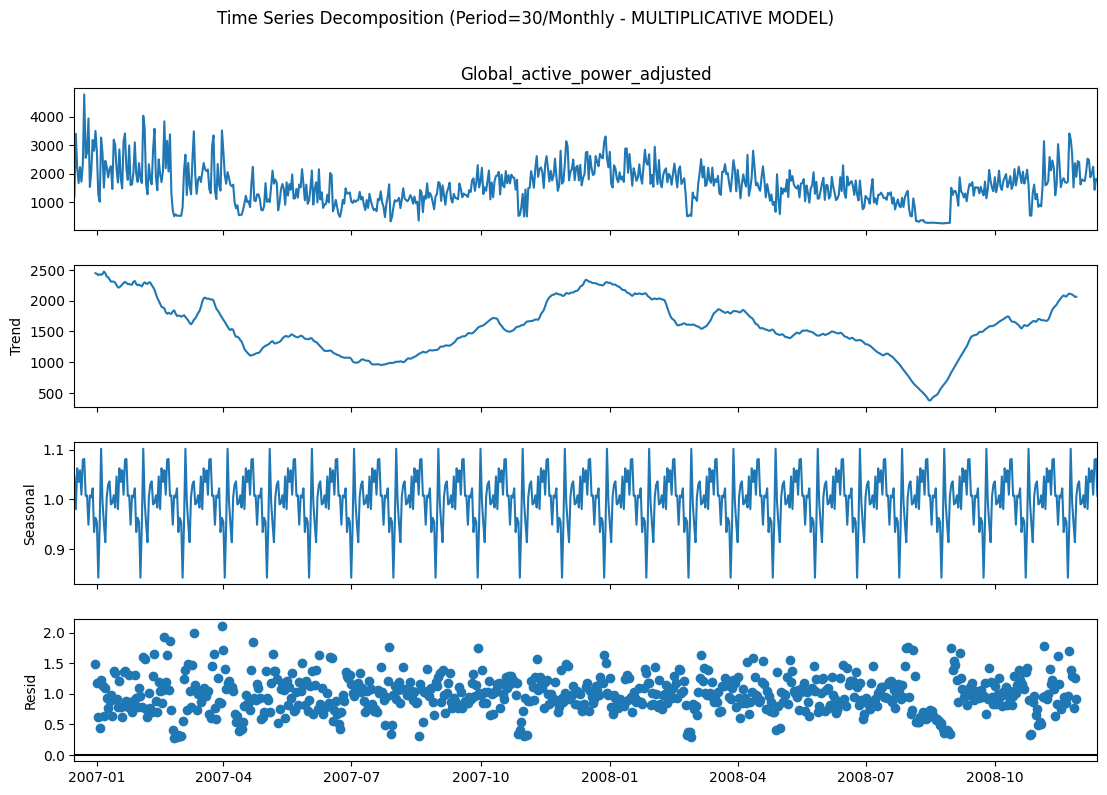

In [ ]:
# period = 30
decomposition_monthly = seasonal_decompose(df_daily['Global_active_power_adjusted'], model='multiplicative', period=30)
fig_monthly = decomposition_monthly.plot()
fig_monthly.set_size_inches(12, 8)
fig_monthly.suptitle('Time Series Decomposition (Period=30/Monthly - MULTIPLICATIVE MODEL)', y=1.02)
plt.show()

Trend: Lebih smooth karena menggunakan window bulanan. Tampak penurunan awal 2007, naik pertengahan 2007–2008, turun sebentar, lalu naik kembali akhir 2008.

Seasonal: Ada pola naik-turun per 30 hari, cukup teratur --> indikasi seasonal bulanan, mungkin terkait dengan pola tagihan/penggunaan rumah tangga.

Residual: Tetap fluktuatif, tapi terlihat noise acak sudah cukup terisolasi.

## Plot Autokorelasi (ACF & FACF)

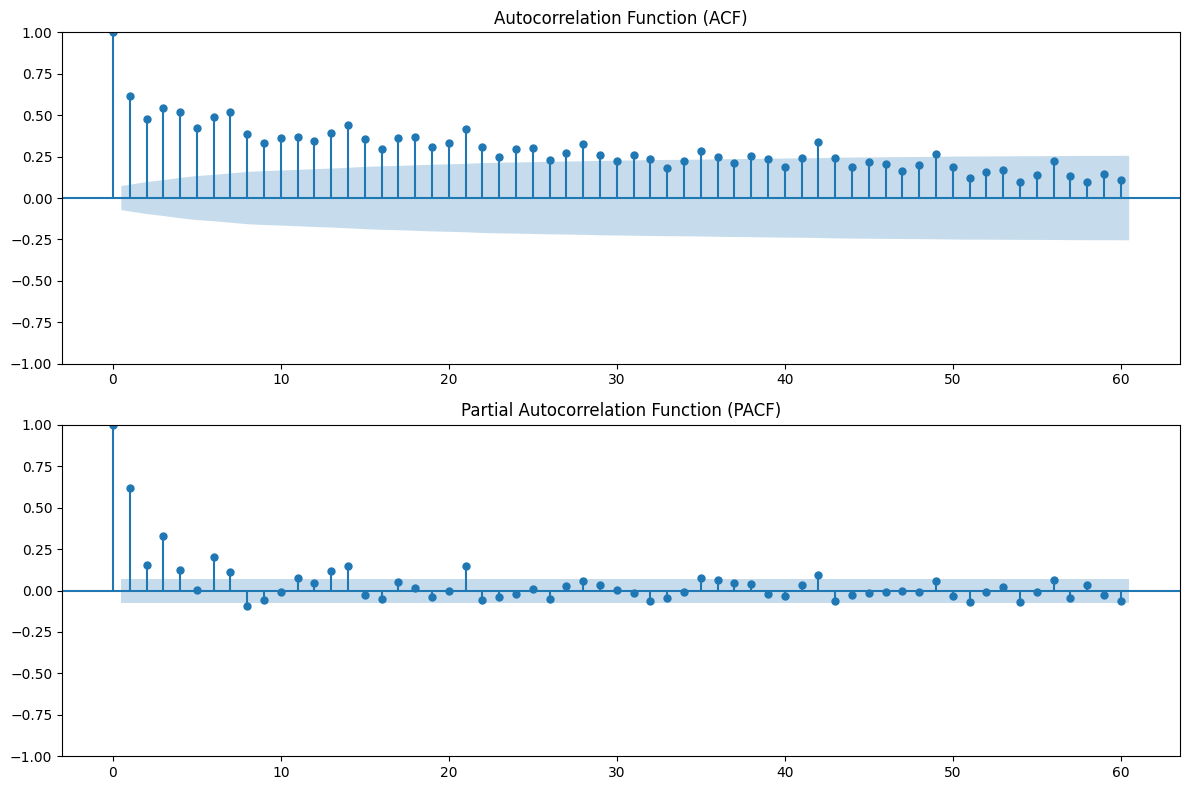

In [ ]:
# Plot Autokorelasi (ACF & PACF)
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(df_daily['Global_active_power'], lags=60, ax=ax[0], title='Autocorrelation Function (ACF)')
plot_pacf(df_daily['Global_active_power'], lags=60, ax=ax[1], title='Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

**ACF (Autocorrelation Function)**

Lag 1–7: Nilai ACF cukup tinggi dan menurun secara bertahap, menunjukkan autokorelasi jangka pendek yang kuat. Ini indikasi adanya persistence atau momentum.

Setelah lag 7, 14, 21, dst: Ada pola penurunan berkala, walau tidak terlalu tajam, ini mengindikasikan adanya musiman mingguan (weekly seasonality).

Nilai tidak langsung turun ke 0 --> ini ciri khas dari proses ARIMA campuran atau non-stationer.

**PACF (Partial Autocorrelation Function)**
Lag 1 sangat tinggi, lalu drop signifikan di lag 2 dan seterusnya. Ciri klasik dari model AR(1).

Lag selanjutnya cenderung kecil --> hanya lag 1 yang signifikan --> cocok untuk ARIMA(p=1).

# Feature Engineering (untuk ML)

In [ ]:
# Ekstraksi Fitur Waktu & Kalender
def create_time_features_daily_power(df_input):
    df_output = df_input.copy()
    df_output['year'] = df_output.index.year
    df_output['month'] = df_output.index.month
    df_output['day'] = df_output.index.day # day of month
    df_output['dayofweek'] = df_output.index.dayofweek
    df_output['dayofyear'] = df_output.index.dayofyear
    df_output['weekofyear'] = df_output.index.isocalendar().week.astype(int)
    df_output['quarter'] = df_output.index.quarter
    df_output['is_weekend'] = (df_output.index.dayofweek >= 5).astype(int) # Sabtu=5, Minggu=6

    # Fitur siklik untuk seasonal
    df_output['dayofweek_sin'] = np.sin(2 * np.pi * df_output['dayofweek']/7)
    df_output['dayofweek_cos'] = np.cos(2 * np.pi * df_output['dayofweek']/7)
    df_output['dayofyear_sin'] = np.sin(2 * np.pi * df_output['dayofyear']/365)
    df_output['dayofyear_cos'] = np.cos(2 * np.pi * df_output['dayofyear']/365)
    df_output['month_sin'] = np.sin(2 * np.pi * df_output['month']/12)
    df_output['month_cos'] = np.cos(2 * np.pi * df_output['month']/12)
    return df_output

df_features = create_time_features_daily_power(df_daily) # gunakan df_daily yang sudah bersih


# Pembuatan Fitur Lag & Rolling Window dari 'Global_active_power'
def create_lag_rolling_features_power(df_input):
    df_temp = df_input.copy()
    target_col = 'Global_active_power'

    # Lag features dari target
    df_temp[f'{target_col}_lag_1'] = df_temp[target_col].shift(1) # Kemarin
    df_temp[f'{target_col}_lag_7'] = df_temp[target_col].shift(7) # Seminggu lalu (seasonal mingguan)
    df_temp[f'{target_col}_lag_365'] = df_temp[target_col].shift(365) # Setahun lalu (seasonal tahunan)

    # Rolling window features dari target
    df_temp[f'{target_col}_rolling_mean_7'] = df_temp[target_col].rolling(window=7, min_periods=1).mean()
    df_temp[f'{target_col}_rolling_std_7'] = df_temp[target_col].rolling(window=7, min_periods=1).std()
    df_temp[f'{target_col}_rolling_mean_30'] = df_temp[target_col].rolling(window=30, min_periods=1).mean()

    return df_temp

df_features = create_lag_rolling_features_power(df_features)


# Penanganan NaN dari Fitur
# Isi NaN yang tersisa setelah shift/rolling dengan rata-rata kolom
for col in df_features.columns:
    if df_features[col].isnull().any():
        df_features[col].fillna(df_features[col].mean(), inplace=True) # Mengisi dengan rata-rata kolom

print(f"Ukuran data setelah feature engineering: {df_features.shape[0]} baris")

Ukuran data setelah feature engineering: 729 baris


# Split Data

In [ ]:
# Pemisahan Data Training & Testing
test_size_days = 365 # Ambil 1 tahun terakhir sebagai test set
split_date = df_features.index.max() - pd.Timedelta(days=test_size_days)

# Definisikan target
target_col = 'Global_active_power'

# Kolom-kolom yang akan digunakan sebagai fitur (selain target) untuk model ML
ml_features = [col for col in df_features.columns if col != target_col]

X_train_full_ml = df_features[df_features.index <= split_date][ml_features]
y_train_full_ml = df_features[df_features.index <= split_date][target_col]
X_test_full_ml = df_features[df_features.index > split_date][ml_features]
y_test_full_ml = df_features[df_features.index > split_date][target_col]

# Data target untuk model Time Series Klasik
y_train_ts = df_daily[target_col][df_daily.index <= split_date]
y_test_ts = df_daily[target_col][df_daily.index > split_date]

# Fitur external/exogenous untuk SARIMAX / Prophet
# Ini adalah kolom-kolom non-target, non-lag/rolling yang bisa jadi prediktor
exog_cols = [
    'Global_reactive_power', 'Voltage', 'Global_intensity',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
    'year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter', 'is_weekend',
    'dayofweek_sin', 'dayofweek_cos', 'dayofyear_sin', 'dayofyear_cos', 'month_sin', 'month_cos'
]
exog_train_ts = df_features[exog_cols][df_features.index <= split_date]
exog_test_ts = df_features[exog_cols][df_features.index > split_date]

print(f"Ukuran Data Training ML: {len(X_train_full_ml)} hari")
print(f"Ukuran Data Testing ML: {len(X_test_full_ml)} hari")
print(f"Ukuran Data Training TS: {len(y_train_ts)} hari")
print(f"Ukuran Data Testing TS: {len(y_test_ts)} hari")

Ukuran Data Training ML: 364 hari
Ukuran Data Testing ML: 365 hari
Ukuran Data Training TS: 364 hari
Ukuran Data Testing TS: 365 hari


# Pemodelan

In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    # Memastikan prediksi tidak negatif (karena konsumsi daya tidak mungkin negatif)
    y_pred = np.maximum(0, y_pred) # Konsumsi tidak bisa negatif
    # Menghitung Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    # Menghitung Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    # Menghitung Mean Absolute Percentage Error (MAPE)
    # Menghindari pembagian dengan nol jika ada nilai aktual 0
    y_true_cleaned = y_true.copy()
    y_true_cleaned[y_true_cleaned == 0] = 1e-9 # Ganti 0 dengan small number untuk menghindari pembagian angka 0

    mape = np.mean(np.abs((y_true - y_pred) / y_true_cleaned)) * 100
    print(f"--- {model_name} ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")

    return rmse, mae, mape


def plot_predictions(y_true, y_pred, model_name):
    plt.figure(figsize=(15, 6)) # Mengatur ukuran gambar
    # Memplot nilai aktual
    plt.plot(y_true.index, y_true, label='Aktual', color='blue')
    # Pastikan y_pred memiliki indeks yang sama dengan y_true untuk plotting yang benar
    # Mengkonversi y_pred menjadi Series pandas jika belum (berguna jika y_pred adalah array numpy)
    if isinstance(y_pred, np.ndarray):
        y_pred_series = pd.Series(y_pred, index=y_true.index)
    else:
        y_pred_series = y_pred
    # Memplot nilai prediksi
    plt.plot(y_true.index, y_pred_series, label=f'Prediksi {model_name}', color='red', linestyle='--', alpha=0.7)
    plt.title(f'Prediksi {model_name} vs Aktual pada Data Testing') # Menambahkan judul plot
    plt.xlabel('Tanggal') # Menambahkan label sumbu x
    plt.ylabel('Power (kW)') # Menambahkan label sumbu y
    plt.legend() # Menampilkan legenda
    plt.tight_layout() # Menyesuaikan layout plot
    plt.show() # Menampilkan plot

## Naive Forecast/Baseline

--- Naive Forecast ---
RMSE: 480.4765
MAE: 363.8064
MAPE: 23.79%


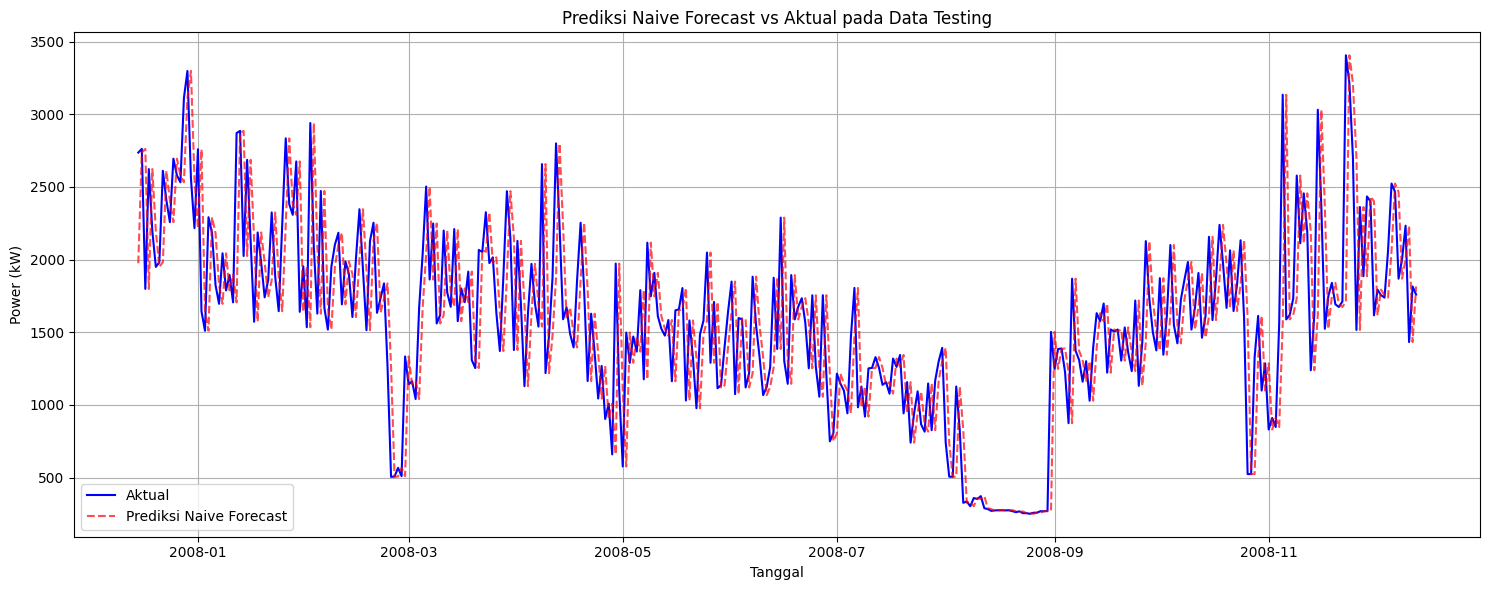

In [ ]:
#  Model 1: Naive Forecast (Baseline)
# Naive forecast memprediksi bahwa nilai besok sama dengan nilai hari ini (nilai sebelumnya)
# Menggeser data testing satu periode ke depan (`shift(1)`)
y_pred_naive = y_test_ts.shift(1)
# Mengisi nilai pertama dari prediksi (yang menjadi NaN karena shift) dengan nilai terakhir dari data training.
y_pred_naive.iloc[0] = y_train_ts.iloc[-1]
rmse_naive, mae_naive, mape_naive = evaluate_model(y_test_ts, y_pred_naive, "Naive Forecast")
plot_predictions(y_test_ts, y_pred_naive, "Naive Forecast")

--- Simple Exponential Smoothing ---
RMSE: 741.4386
MAE: 589.2327
MAPE: 79.81%


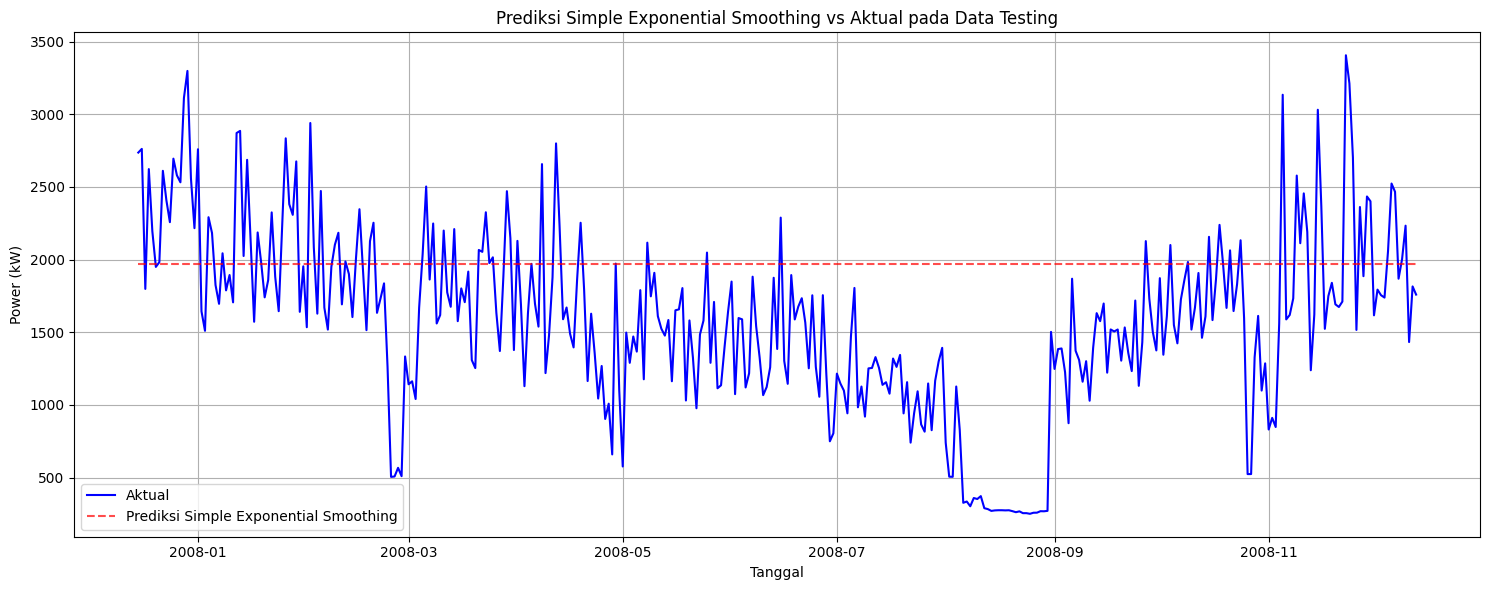

In [ ]:
#  Model 2: Simple Exponential Smoothing (SES)
# SES tidak memiliki komponen tren (trend=None) dan musiman (seasonal=None).
ses_model = ExponentialSmoothing(y_train_ts, trend=None, seasonal=None).fit()
y_pred_ses = ses_model.forecast(len(y_test_ts))
rmse_ses, mae_ses, mape_ses = evaluate_model(y_test_ts, y_pred_ses, "Simple Exponential Smoothing")
plot_predictions(y_test_ts, y_pred_ses, "Simple Exponential Smoothing")

## Holt-Winters (Triple Exponential Smoothing)

--- Holt-Winters ---
RMSE: 736.1407
MAE: 554.2283
MAPE: 48.81%


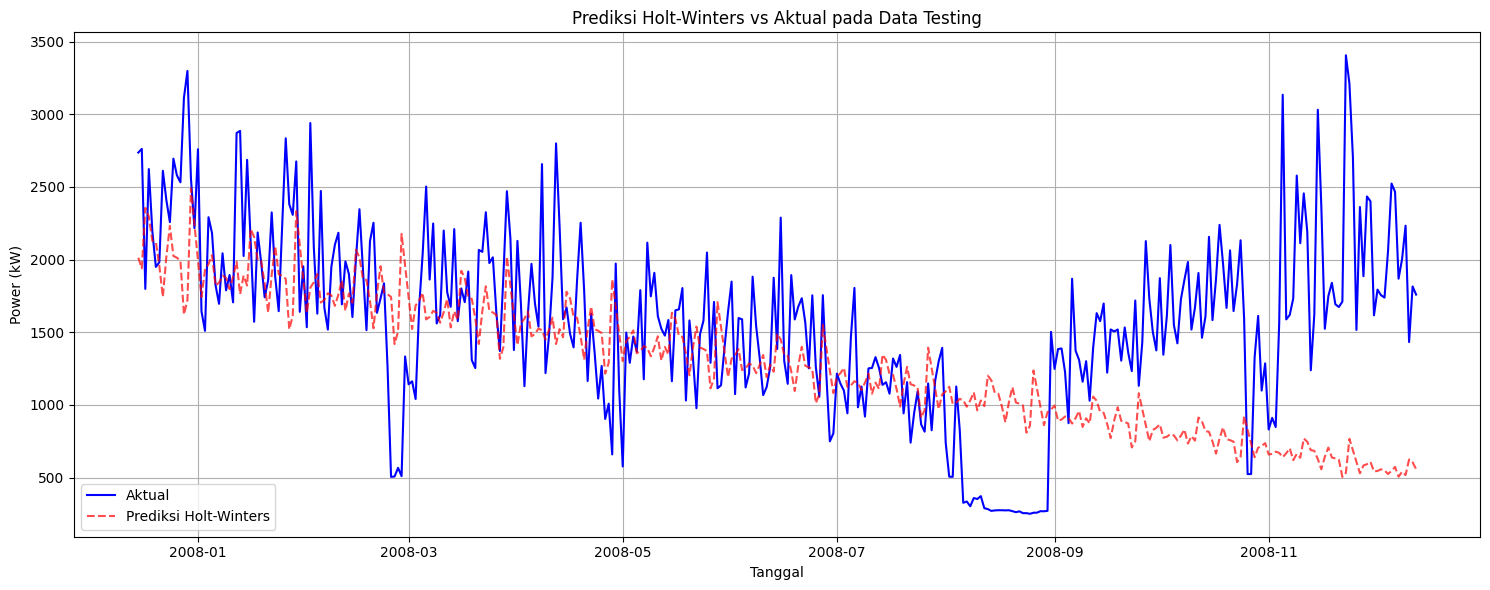

In [ ]:
#  Model 3: Holt-Winters (Triple Exponential Smoothing)
# Konsumsi listrik kemungkinan memiliki musiman multiplikatif
hw_model = ExponentialSmoothing(y_train_ts, trend='add', seasonal='multiplicative', seasonal_periods=30).fit()
y_pred_hw = hw_model.forecast(len(y_test_ts))
rmse_hw, mae_hw, mape_hw = evaluate_model(y_test_ts, y_pred_hw, "Holt-Winters")
plot_predictions(y_test_ts, y_pred_hw, "Holt-Winters")

Dari hasil evaluasi tiga model baseline dan exponential smoothing, berikut adalah interpretasinya:

1.  **Naive Forecast**:
    *   RMSE: 480.4765
    *   MAE: 363.8064
    *   MAPE: 23.79%
    
    Model Naive forecast adalah baseline sederhana yang memprediksi nilai hari ini sama dengan nilai kemarin. Model ini menghasilkan nilai RMSE dan MAE yang paling rendah di antara ketiga model, serta MAPE yang juga paling rendah (23.79%). Ini menunjukkan bahwa dalam data testing (yang merupakan satu tahun terakhir), nilai konsumsi listrik cenderung tidak berubah drastis dari satu hari ke hari berikutnya, atau setidaknya perubahan hariannya relatif kecil dibandingkan dengan fluktuasi keseluruhan.

2.  **Simple Exponential Smoothing (SES)**:
    *   RMSE: 741.4386
    *   MAE: 589.2327
    *   MAPE: 79.81%
    
    SES hanya mempertimbangkan level data (rata-rata) dan tidak mempertimbangkan tren atau seasonal. Hasilnya menunjukkan performa yang paling buruk di antara ketiganya untuk semua metrik. RMSE dan MAE jauh lebih tinggi daripada Naive, dan MAPE bahkan sangat tinggi (79.81%). Ini mengindikasikan bahwa data memiliki komponen tren dan/atau seasonal yang signifikan, sehingga model sederhana seperti SES yang mengabaikannya tidak dapat menangkap pola tersebut dengan baik.

3.  **Holt-Winters (Triple Exponential Smoothing)**:
    *   RMSE: 736.1407
    *   MAE: 554.2283
    *   MAPE: 48.81%
    
    Model Holt-Winters mencoba menangkap level, tren (aditif), dan musiman (multiplikatif dengan periode 30 hari). Meskipun secara metrik (RMSE dan MAE) sedikit lebih baik dari SES, performanya masih jauh lebih buruk dibandingkan Naive forecast. MAPE-nya (48.81%) juga jauh lebih tinggi dari Naive, meskipun lebih baik dari SES. Hasil ini cukup mengagetkan karena Holt-Winters seharusnya lebih canggih daripada Naive dan SES, terutama dengan kemampuan menangkap tren dan musiman. Beberapa kemungkinan alasannya adalah:

        *   Seasonal harian yang dominan (periode 7) mungkin lebih penting daripada seasonal bulanan (periode 30) yang digunakan di sini, atau kombinasi keduanya perlu dipertimbangkan.
        *   Seasonal mungkin tidak murni aditif atau multiplikatif, atau strukturnya lebih kompleks.
        *   Data testing mungkin memiliki fluktuasi yang sangat tinggi atau outlier yang tidak dapat ditangani oleh model smoothing ini.
        *   Periode seasonal 30 hari mungkin tidak optimal untuk data ini, atau fitting model pada data training menghasilkan parameter yang tidak generalisasi dengan baik ke data testing.

**Kesimpulan Sementara**:

Dari ketiga model ini, **Naive Forecast** surprisingly memberikan performa terbaik pada data testing berdasarkan semua metrik evaluasi. Ini menyiratkan bahwa fluktuasi harian dalam data testing mungkin didominasi oleh noise atau pola yang sangat berubah-ubah, sehingga model yang lebih canggih yang mencoba menangkap tren dan seasonal jangka panjang (seperti Holt-Winters dengan seasonal_periods=30) malah kurang akurat dalam memprediksi nilai satu hari ke depan dibandingkan hanya mengikuti nilai hari sebelumnya.

Hasil ini menunjukkan pentingnya selalu memiliki baseline seperti Naive forecast. Model yang lebih kompleks (SES, Holt-Winters) tidak selalu lebih baik, terutama jika asumsi model tidak sepenuhnya cocok dengan karakteristik data aktual pada periode forecasting.

Note: Perlu dicatat bahwa Holt-Winters diuji dengan `seasonal_periods=30`. Mungkin bisa mencoba `seasonal_periods=7` (untuk seasonal mingguan).

## SARIMAX

--- SARIMAX (0,0,1)(1,1,1,30) ---
RMSE: 88.1127
MAE: 69.5084
MAPE: 5.85%


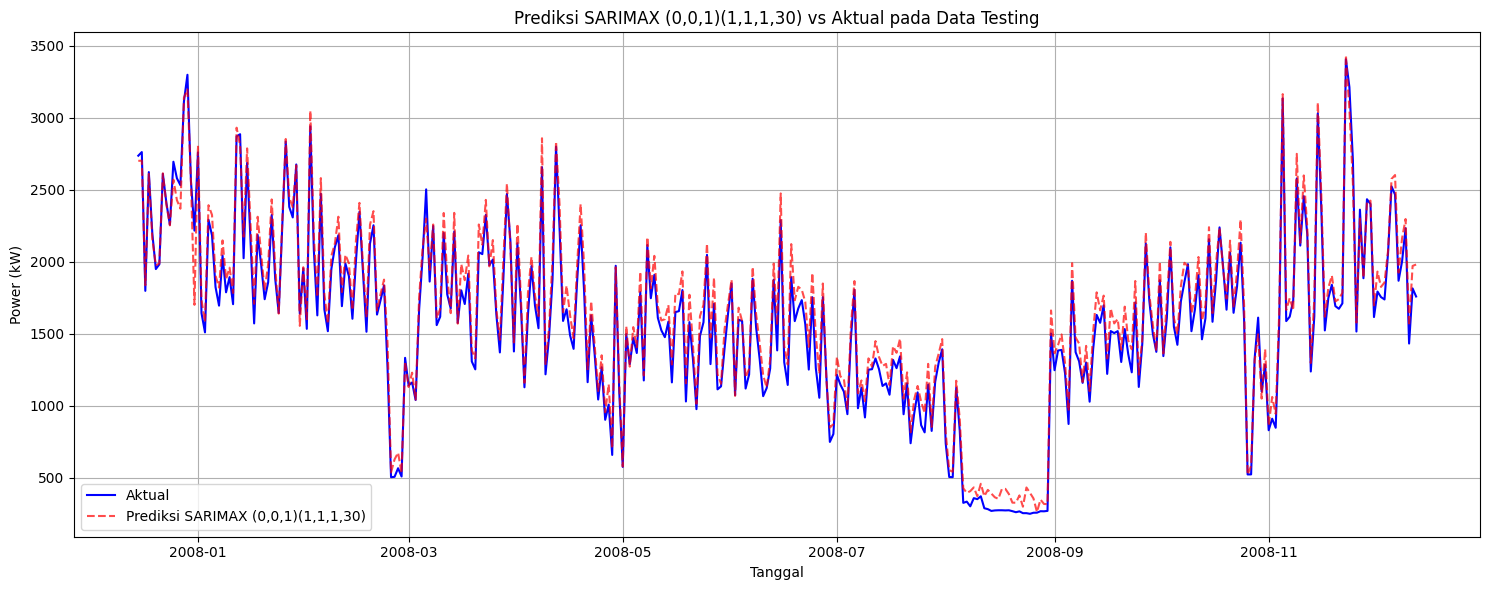

In [ ]:
# Model 4: SARIMAX dengan order (0, 0, 1) dan seasonal_order (1, 1, 1, 30)
# (p, d, q) = (0, 0, 1): Bagian non-seasonal
#   p=0: Tidak ada komponen Autoregressive (AR) non-seasonal
#   d=0: Tidak ada differencing non-seasonal
#   q=1: Ada komponen Moving Average (MA) non-seasonal orde 1. Nilai sekarang dipengaruhi oleh error dari satu periode sebelumnya
# (P, D, Q, s) = (1, 1, 1, 30): Bagian seasonal
#   P=1: Ada komponen Autoregressive (AR) seasonal orde 1. Nilai sekarang dipengaruhi oleh nilai 30 periode sebelumnya
#   D=1: Ada seasonal differencing orde 1. Menangani seasonal (period=30) yang tren atau non-stasioner
#   Q=1: Ada komponen Moving Average (MA) seasonal orde 1. Nilai sekarang dipengaruhi oleh error seasonal dari 30 periode sebelumnya
#   s=30: Periode seasonal adalah 30 hari.
# Menggunakan variabel eksogen (exog_train_ts dan exog_test_ts)

sarimax_model = ARIMA(y_train_ts,
                                 exog=exog_train_ts, # Menggunakan variabel eksogen
                                 order=(0, 0, 1),       # (p, d, q) - Bagian non-seasonal
                                 seasonal_order=(1, 1, 1, 30)).fit() # (P, D, Q, s) - Bagian seasonal

y_pred_sarimax = sarimax_model.forecast(steps=len(y_test_ts), exog=exog_test_ts)
rmse_sarimax, mae_sarimax, mape_sarimax = evaluate_model(y_test_ts, y_pred_sarimax, "SARIMAX (0,0,1)(1,1,1,30)")
plot_predictions(y_test_ts, y_pred_sarimax_specific, "SARIMAX (0,0,1)(1,1,1,30)")




Secara keseluruhan, model SARIMAX yang telah dilatih menunjukkan kinerja yang cukup dalam memprediksi konsumsi daya harian listrik pada data testing.

*   **Tingkat Error Relatif:** MAPE sebesar 5.85% menunjukkan bahwa model cukup akurat, dengan rata-rata meleset sekitar 6% dari konsumsi daya listrik yang sebenarnya. Tingkat error di bawah 10% seringkali dianggap dapat diterima untuk banyak aplikasi peramalan.
*   **Tingkat Error Absolut:** MAE (sekitar 70 kW) dan RMSE (sekitar 88 kW) memberikan gambaran besaran error dalam satuan kW. Angka-angka ini perlu dibandingkan dengan rata-rata atau rentang nilai konsumsi daya listrik harian untuk menilainya lebih lanjut (misalnya, jika rata-rata konsumsi harian adalah 1000 kW, maka error rata-rata 70 kW mungkin dianggap kecil; jika rata-rata hanya 200 kW, maka 70 kW adalah error yang signifikan).


## Prophet

DEBUG:cmdstanpy:input tempfile: /tmp/tmpukwic3u9/36ef4zy0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpukwic3u9/8k8_9a44.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87784', 'data', 'file=/tmp/tmpukwic3u9/36ef4zy0.json', 'init=/tmp/tmpukwic3u9/8k8_9a44.json', 'output', 'file=/tmp/tmpukwic3u9/prophet_model6eq2h1g1/prophet_model-20250616163654.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:36:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:36:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--- Prophet ---
RMSE: 287.7657
MAE: 277.3943
MAPE: 24.99%


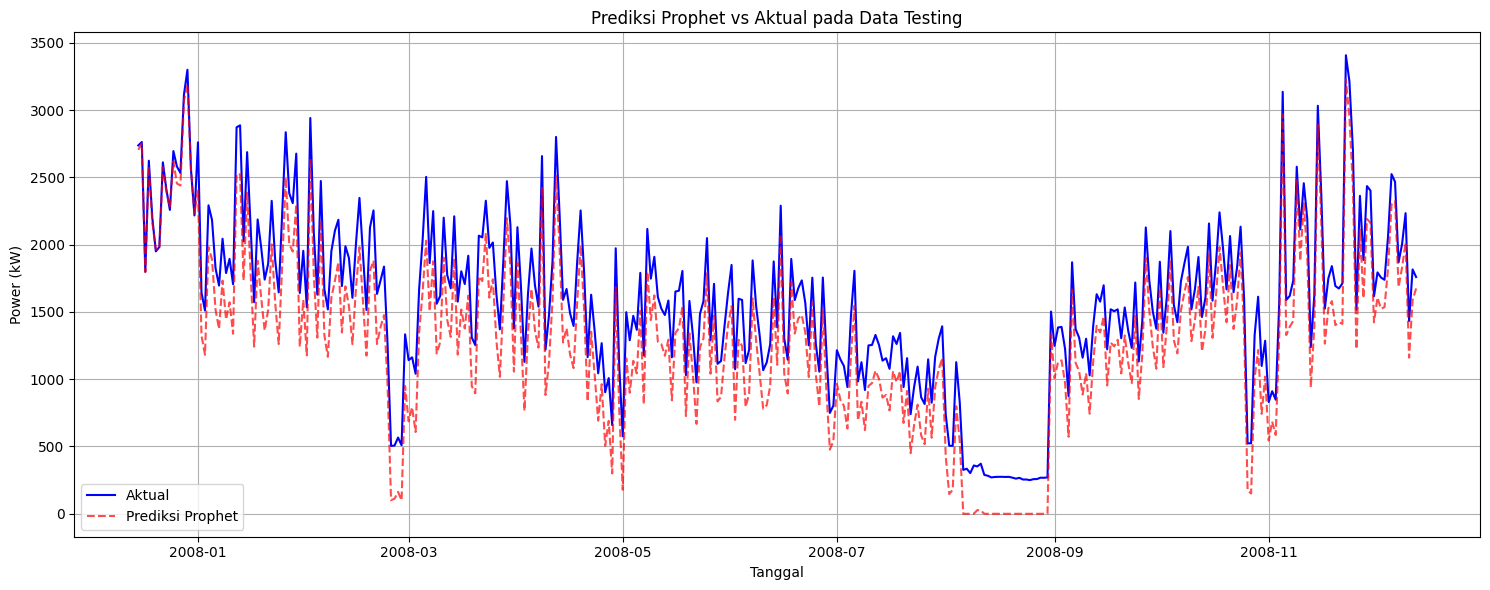

In [ ]:
#  Model 5: Prophet (dengan external variables)

# Prophet memerlukan nama kolom 'ds' untuk waktu dan 'y' untuk nilai target
# Buat dataframe untuk Prophet dari data time series training dan testing
prophet_df_train = y_train_ts.reset_index().rename(columns={'datetime': 'ds', 'Global_active_power': 'y'})
prophet_df_test = y_test_ts.reset_index().rename(columns={'datetime': 'ds', 'Global_active_power': 'y'})

# Define exog_cols using columns from exog_train_ts excluding the index
exog_cols = [col for col in exog_train_ts.columns if col != exog_train_ts.index.name]


# seasonality_mode='multiplicative' (sesuai dengan observasi dari dekomposisi)
# Mengaktifkan seasonality harian dan mingguan.
# changepoint_prior_scale mengontrol fleksibilitas tren
m = Prophet(seasonality_mode='multiplicative',
            yearly_seasonality=False,
            weekly_seasonality=True,
            daily_seasonality=True,
            changepoint_prior_scale=0.05)

# Menambahkan variabel eksogen/external ke model Prophet
for col in exog_cols:
    m.add_regressor(col)

# Menggabungkan data training Prophet dengan data variabel eksogen training
prophet_train_with_exog = pd.merge(prophet_df_train, exog_train_ts.reset_index().rename(columns={'datetime':'ds'}), on='ds', how='left')
# Train model Prophet dengan data training dan eksogen
m.fit(prophet_train_with_exog)

# membuat DataFrame future untuk periode prediksi (data testing)
future = m.make_future_dataframe(periods=len(y_test_ts), freq='D', include_history=False)
# menggabungkan DataFrame future dengan data variabel eksogen testing
future = pd.merge(future, exog_test_ts.reset_index().rename(columns={'datetime': 'ds'}), on='ds', how='left')

# prediksi
forecast = m.predict(future)
# Mengambil kolom prediksi ('yhat')
y_pred_prophet = forecast['yhat'].values

# Memastikan prediksinya non-negative
y_pred_prophet = np.maximum(0, y_pred_prophet)

y_pred_prophet_series = pd.Series(y_pred_prophet, index=y_test_ts.index)

rmse_prophet, mae_prophet, mape_prophet = evaluate_model(y_test_ts, y_pred_prophet, "Prophet")
plot_predictions(y_test_ts, y_pred_prophet_series, "Prophet")


*   **RMSE (Root Mean Squared Error): 287.7657**

    Berarti rata-rata prediksi model Prophet menyimpang sekitar 287.77 kW dari nilai aktual.

*   **MAE (Mean Absolute Error): 277.3943**

    Nilai 277.3943 berarti  prediksi model Prophet menyimpang sekitar 277.39 kW dari nilai aktual, tanpa mempertimbangkan arah kesalahan (lebih tinggi atau lebih rendah).

*   **MAPE (Mean Absolute Percentage Error): 24.99%**

    Berarti bahwa secara rata-rata, prediksi model Prophet menyimpang sekitar 25% dari nilai aktual.


## LightGBM

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2062
[LightGBM] [Info] Number of data points in the train set: 364, number of used features: 26
[LightGBM] [Info] Start training from score 1605.045415
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

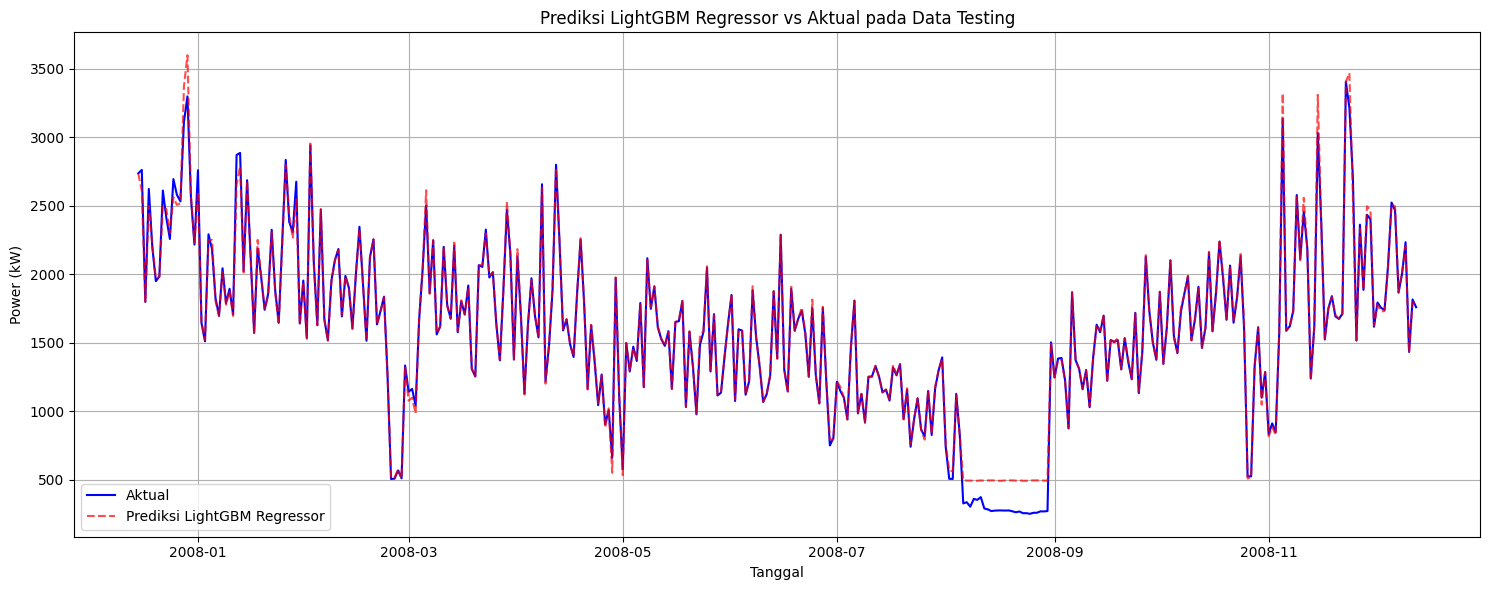

In [ ]:
#  Model 6: LightGBM Regressor
# objective='regression_l2' (MSE), metric='rmse', random_state untuk reproduksibilitas, n_estimators jumlah boosting rounds
lgbm_model = lgb.LGBMRegressor(objective='regression_l2', metric='rmse', random_state=42, n_estimators=1000)

# eval_set digunakan untuk evaluasi performa pada data testing selama training (untuk early stopping)
# eval_metric metrik evaluasi
# callbacks digunakan untuk early stopping (menghentikan training jika metrik pada eval_set tidak membaik setelah 100 iterasi)
lgbm_model.fit(X_train_full_ml, y_train_full_ml,
               eval_set=[(X_test_full_ml, y_test_full_ml)],
               eval_metric='rmse',
               callbacks=[lgb.early_stopping(100, verbose=False)])

# prediksi
y_pred_lgbm = lgbm_model.predict(X_test_full_ml)
rmse_lgbm, mae_lgbm, mape_lgbm = evaluate_model(y_test_full_ml, y_pred_lgbm, "LightGBM Regressor")

plot_predictions(y_test_full_ml, y_pred_lgbm, "LightGBM Regressor")


Berdasarkan metrik evaluasi:

*   **RMSE: 69.8443**: Rata-rata error kuadrat akar prediksi LightGBM adalah sekitar 69.84 kW.
*   **MAE: 32.4191**: Rata-rata error absolut prediksi LightGBM adalah sekitar 32.42 kW.
*   **MAPE: 6.16%**: Rata-rata error dalam persentase dari nilai aktual adalah sekitar 6.16%.

Angka-angka ini menunjukkan bahwa model LightGBM memiliki performa yang cukup baik dalam memprediksi konsumsi daya harian, dengan tingkat kesalahan relatif yang terbilang rendah (sekitar 6%).

--- Random Forest Regressor ---
RMSE: 29.8144
MAE: 13.6216
MAPE: 2.95%


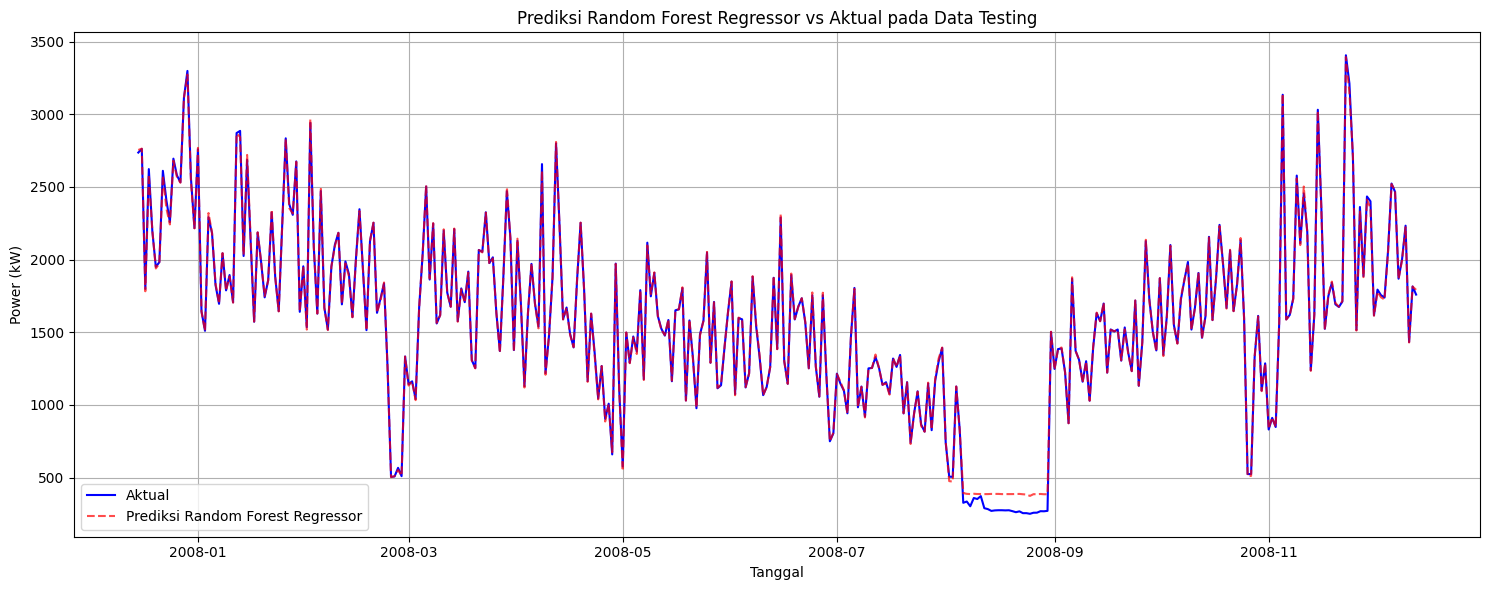

In [ ]:
# --- Model 7: Random Forest Regressor ---
# n_estimators jumlah pohon, random_state, n_jobs=-1 menggunakan semua core CPU
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
# train
rf_model.fit(X_train_full_ml, y_train_full_ml)

# predict
y_pred_rf = rf_model.predict(X_test_full_ml)
rmse_rf, mae_rf, mape_rf = evaluate_model(y_test_full_ml, y_pred_rf, "Random Forest Regressor")
plot_predictions(y_test_full_ml, y_pred_rf, "Random Forest Regressor")





Metrik evaluasi untuk model Random Forest Regressor menunjukkan hal berikut:

*   **RMSE: 29.8144**: Ini berarti, rata-rata perbedaan antara nilai aktual dan nilai prediksi dari model Random Forest, setelah dikuadratkan dan diakar, adalah sekitar 29.81 kW. Angka yang lebih rendah menunjukkan model memiliki kesalahan yang lebih kecil. Dibandingkan dengan model LightGBM (RMSE 69.84), Random Forest memiliki RMSE yang jauh lebih rendah, menunjukkan akurasi yang lebih baik dalam hal rata-rata magnitude kesalahan.

*   **MAE: 13.6216**: Ini menunjukkan bahwa, rata-rata perbedaan absolut antara nilai aktual dan nilai prediksi adalah sekitar 13.62 kW. Sama seperti RMSE, angka yang lebih rendah menunjukkan akurasi yang lebih baik. MAE ini juga lebih rendah dari MAE LightGBM (32.42). MAE memberikan gambaran langsung tentang seberapa besar kesalahan prediksi pada rata-rata dalam unit atau satuan yang sama (kW).

*   **MAPE: 2.95%**: Ini berarti, rata-rata kesalahan prediksi model Random Forest dalam persentase dari nilai aktual adalah sekitar 2.95%. Angka ini sangat rendah, menunjukkan bahwa model Random Forest mampu memprediksi nilai konsumsi daya harian dengan akurasi persentase yang sangat baik. Dibandingkan dengan MAPE LightGBM (6.16%) dan terutama Prophet (24.99%), MAPE Random Forest jauh lebih rendah, menjadikannya model dengan performa persentase error terbaik di antara lainnya.



Berdasarkan metrik RMSE, MAE, dan MAPE, model Random Forest Regressor menunjukkan performa yang **sangat baik** dalam memprediksi konsumsi daya harian pada data testing. Angka-angka metriknya secara signifikan lebih rendah dibandingkan model-model lain seperti Naive Forecast, SES, SARIMAX, Prophet, dan LightGBM. Secara khusus, MAPE sebesar 2.95% menunjukkan bahwa prediksi model ini rata-rata hanya melenceng kurang dari 3% dari nilai aktual, yang merupakan hasil yang sangat presisi.

In [ ]:
# Membuat performance summary
print("="*50)
print("Ringkasan Performa MAPE Seluruh Model")
print("="*50)
# Koleksi MAPE dari setiap model
results = {
    "Naive Forecast": mape_naive,
    "Simple Exponential Smoothing": mape_ses,
    "Holt-Winters": mape_hw,
    "SARIMAX": mape_sarimax,
    "Prophet": mape_prophet,
    "LightGBM Regressor": mape_lgbm,
    "Random Forest Regressor": mape_rf
}

for model_name, mape_val in results.items():
    print(f"{model_name:<30} MAPE: {mape_val:.4f}")

print("="*50 + "\n")

Ringkasan Performa MAPE Seluruh Model
Naive Forecast                 MAPE: 23.7891
Simple Exponential Smoothing   MAPE: 79.8143
Holt-Winters                   MAPE: 48.8113
SARIMAX                        MAPE: 5.8483
Prophet                        MAPE: 24.9929
LightGBM Regressor             MAPE: 6.1559
Random Forest Regressor        MAPE: 2.9525

